# Task 3

In [1]:
import  numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import time 
import os

from langchain_groq.chat_models import ChatGroq

from sklearn.decomposition import PCA
import random

In [2]:
with open(r'C:\Users\LENOVO\Desktop\ML assignment 1\api_key.txt', 'r') as f:
    Groq_token = f.read().strip()

In [3]:
llm = ChatGroq(model = "llama3-70b-8192", api_key = Groq_token, temperature=1)

In [4]:
x_train_tsfel = pd.read_csv(r"C:\Users\LENOVO\Desktop\ML assignment 1\X_train_tsfel.csv")
y_train_tsfel = pd.read_csv(r"C:\Users\LENOVO\Desktop\ML assignment 1\y_train_tsfel.csv", names = ["activity_label"])

x_test_tsfel = pd.read_csv(r"C:\Users\LENOVO\Desktop\ML assignment 1\X_test_tsfel.csv")
y_test_tsfel = pd.read_csv(r"C:\Users\LENOVO\Desktop\ML assignment 1\y_test_tsfel.csv", names = ["activity_label"])

x_collected_tsfel = pd.read_csv(r"C:\Users\LENOVO\Desktop\ML assignment 1\X_collected_tsfel.csv")
y_collected_tsfel = pd.read_csv(r"C:\Users\LENOVO\Desktop\ML assignment 1\y_collected_tsfel.csv", names = ["activity_label"])

In [5]:
activity_dictionary = {
    1: 'WALKING',
    2: 'WALKING UPSTAIRS',
    3: 'WALKING DOWNSTAIRS',
    4: 'SITTING',
    5: 'STANDING',
    6: 'LAYING'
}

activities = ['WALKING',
    'WALKING UPSTAIRS',
    'WALKING DOWNSTAIRS',
    'SITTING',
    'STANDING',
    'LAYING']

In [6]:
activity_feature_vectors = {}
for activity in activities:
    activity_feature_vectors[activity] = []

In [7]:
for i in range(1, 7):
    activity_df = x_train_tsfel[np.array(y_train_tsfel["activity_label"], dtype = 'int32') == i]
    for _ in range(3):
        random_choice = np.random.choice(range(len(activity_df)))
        activity_example = activity_df.iloc[random_choice].values.ravel()
        activity_feature_vectors[activity_dictionary[i]].append(activity_example)

# DO NOT EXECUTE THE BELOW CODE CELLS

### Task 3.1
#### Demonstrate how to use Zero-Shot Learning and Few-Shot Learning to classify human activities based on the featurized accelerometer data. Qualitatively demonstrate the performance of Few-Shot Learning with Zero-Shot Learning. Which method performs better? Why?

##### Zero shot

In [77]:
qualitative_query_zero_shot = f"""
**Ignore all previous instructions**

* You are a multiclass classifier model
* You will be given below readings of humans performing one of the following six physical activities with the activity_labels {activity_dictionary}
* Your task is to analyze the given input readings and predict which of the mentioned activities is the participant performing.
* Provide the activity name(not the label), also make sure to give a brief reasoning as well.

Input: {x_test_tsfel.iloc[0, :]}
""" 

In [78]:
zero_shot_answer = llm.invoke(qualitative_query_zero_shot)
print(f"Correct Label: {activity_dictionary[np.array(y_test_tsfel.iloc[0], dtype = "int32")[0]]}")
print(f"Model Prediction: {zero_shot_answer.content}")

Correct Label: WALKING DOWNSTAIRS
Model Prediction: Based on the input readings, I predict that the participant is **WALKING**.

My reasoning is as follows:

* The high values of absolute energy (553.192673) and average power (110.860255) suggest that the participant is engaging in a dynamic activity that involves significant movement.
* The wavelet variance features (e.g., 2_Wavelet variance_5, 2_Wavelet variance_6, etc.) have relatively low values, which is consistent with walking, as it involves a repetitive motion with minimal sudden changes.
* The autocorrelation feature has a value of 5.000000, which indicates a strong periodicity in the signal, characteristic of walking.
* The centroid feature has a moderate value (2.475640), which suggests that the participant is moving in a somewhat continuous manner, rather than making sudden changes in direction or pace.

Taking into account these factors, I conclude that the participant is most likely walking.


##### Few shot

In [79]:
qualitative_query_few_shot = f"""

**Forget all previous instructions**

* You are a multiclass classifier model.
* You will be given TSFEL featurized readings of humans performing one of the following 6 physical activities: WALKING, WALKING UPSTAIRS, WALKING DOWNSTAIRS, SITTING,  STANDING, LAYING
* The 1152 dimensional vector

Here are a few examples to illustrate:

{activity_feature_vectors}

* Provide a brief reasoning for your prediction as well
For the input data below, VERY CAREFULLY identify the activity being performed: Input --> {x_test_tsfel.iloc[0, :]}
"""

In [80]:
few_shot_answer = llm.invoke(qualitative_query_few_shot)
print(f"Correct Label: {activity_dictionary[np.array(y_test_tsfel.iloc[0, :], dtype = "int32")[0]]}")
print(f"Model Prediction: {few_shot_answer.content}")

Correct Label: WALKING DOWNSTAIRS
Model Prediction: Based on the input data, I predict that the activity being performed is **WALKING**.

Here's a brief reasoning for my prediction:

The input data shows a relatively high absolute energy value (553.192673) and average power (110.860255), which suggests a dynamic and energetic activity. The centroid value (2.475640) also indicates a moderate frequency range, which is consistent with walking.

Additionally, the wavelet variance values (e.g., 0.044262, 0.053273, 0.059316, 0.062127) are relatively high, suggesting a moderate to high level of signal complexity, which is typical of walking activities.

The zero-crossing rate (66.000000) is also relatively high, indicating a significant amount of signal fluctuation, which is consistent with the oscillatory patterns observed during walking.

Overall, the combination of these features suggests that the activity being performed is likely **WALKING**.

Please note that this prediction is based on

Even though both the outputs are incorrect, we can see from both the outputs:</br>
<br>
 ``` Which model performs better? ```<br>
  ```Few shot``` model has a more coherent reasoning for the activity label that it is trying to predict; and </br>
     ---> it methodically eliminates the static activities as they are not very likely to be the correct label<br>
     ---> and then tries to be more specific about which of the dynamic activities it might be <br>
     <br>
   
 ``` Why the few shot prompt performs better? ```<br>
Few shot prompting method performs better than Zero shot prompting. This is because: <br>
* Few shot prompting gives the model more context and clarity in comparison to zero shot prormpting,<br>
  which helps in preventing the LLM from hallucinating, a huge problem among the transformer architecture LLMs
* Zero shot and few shot learning's human analogous are: <br>
    --> in zero shot learning: an untrained human predicting something <br>
    --> in few shot learning: a human that has little domain knowledge of the task trying to make some predictions <br>

And it is clear, which of these will turn out better, which has also been demonstrated qualitatively, and later, quantitatively as well<br>
I have done this only for a single sample but almost the same qualitative results can be observed for other samples from the test data as well.

## Task 3.2
#### Quantitatively compare the accuracy of Few-Shot Learning with Decision Trees (You may use a subset of the test set if you encounter rate-limiting issues). Which method performs better? Why?

In [24]:
zero_shot_predictions = []
i = 0

for test_data, test_label in zip(np.array(x_test_tsfel), np.array(y_test_tsfel, dtype = 'int32')):
    quantitative_query_zero_shot = f"""

**Forget all previous instructions**

* You are a multiclass classifier model.
* You will be given TSFEL featurized readings of humans performing one of the following 6 physical activities: WALKING, WALKING UPSTAIRS, WALKING DOWNSTAIRS, SITTING,  STANDING, LAYING
* The 1152 dimensional vector has been reduced to 25 dimensions using PCA


* Provide ONLY the activity name. NOTHING ELSE.
For the input data below, VERY CAREFULLY identify the activity being performed: Input --> {test_data}
    """ 

    zero_shot_answer = llm.invoke(quantitative_query_zero_shot)
    zero_shot_predictions.append(zero_shot_answer.content)

    i += 1
    print("Test sample number:", i)
    print("Zero shot:",zero_shot_answer.content)
    # print(quantitative_query_few_shot)
    
    print("Correct:", activity_dictionary[test_label[0]])
    # print(few_shot_predictions)    
    print("---------------------------------------------------------")
    time.sleep(1.5)

Test sample number: 1
Zero shot: WALKING
Correct: WALKING DOWNSTAIRS
---------------------------------------------------------
Test sample number: 2
Zero shot: WALKING
Correct: WALKING
---------------------------------------------------------
Test sample number: 3
Zero shot: WALKING
Correct: WALKING UPSTAIRS
---------------------------------------------------------
Test sample number: 4
Zero shot: WALKING UPSTAIRS
Correct: STANDING
---------------------------------------------------------
Test sample number: 5
Zero shot: STANDING
Correct: STANDING
---------------------------------------------------------
Test sample number: 6
Zero shot: WALKING
Correct: WALKING
---------------------------------------------------------
Test sample number: 7
Zero shot: WALKING
Correct: WALKING
---------------------------------------------------------
Test sample number: 8
Zero shot: WALKING
Correct: STANDING
---------------------------------------------------------
Test sample number: 9
Zero shot: WALKIN

In [17]:
few_shot_predictions = []
i = 0

for test_data, test_label in zip(np.array(x_test_tsfel), np.array(y_test_tsfel, dtype = 'int32')):
    quantitative_query_few_shot = f"""

**Forget all previous instructions**

* You are a multiclass classifier model.
* You will be given TSFEL featurized readings of humans performing one of the following 6 physical activities: WALKING, WALKING UPSTAIRS, WALKING DOWNSTAIRS, SITTING,  STANDING, LAYING
* The 1152 dimensional vector

Here are a few examples to illustrate:

{activity_feature_vectors}

* Provide ONLY the activity name. NOTHING ELSE.
For the input data below, VERY CAREFULLY identify the activity being performed: Input --> {test_data}
    """ 
    few_shot_answer = llm.invoke(quantitative_query_few_shot)
    few_shot_predictions.append(few_shot_answer.content)

    i += 1
    print("Test sample number:", i)
    print("Few shot:",few_shot_answer.content)
    # print(quantitative_query_few_shot)
    
    print("Correct:", activity_dictionary[test_label[0]])
    # print(few_shot_predictions)    
    print("---------------------------------------------------------")
    time.sleep(1.5)

Test sample number: 1
Few shot: WALKING UPSTAIRS
Correct: WALKING DOWNSTAIRS
---------------------------------------------------------
Test sample number: 2
Few shot: WALKING
Correct: WALKING
---------------------------------------------------------
Test sample number: 3
Few shot: WALKING
Correct: WALKING UPSTAIRS
---------------------------------------------------------
Test sample number: 4
Few shot: STANDING
Correct: STANDING
---------------------------------------------------------
Test sample number: 5
Few shot: SITTING
Correct: STANDING
---------------------------------------------------------
Test sample number: 6
Few shot: WALKING
Correct: WALKING
---------------------------------------------------------
Test sample number: 7
Few shot: STANDING
Correct: WALKING
---------------------------------------------------------
Test sample number: 8
Few shot: STANDING
Correct: STANDING
---------------------------------------------------------
Test sample number: 9
Few shot: WALKING
Corre

In [95]:
y_test = []
for label in list(np.array(y_test_tsfel, dtype = "int32").ravel()):
    y_test.append(activity_dictionary[label])

In [26]:
import joblib

joblib.dump(y_test, 'y_test_48.pkl')
joblib.dump(few_shot_predictions, 'few_shot_predictions_48.pkl')
joblib.dump(zero_shot_predictions, 'zero_shot_predictions_48.pkl')

['zero_shot_predictions_48.pkl']

In [96]:
def accuracy(y_true, y_pred):
    y_true = np.array(y_true[:len(y_pred)])
    y_pred = np.array(y_pred)
    correct = y_true == y_pred
    # print(correct)
    return(np.sum(correct)/len(y_true))

In [25]:
print("Zero shot accuracy: ")
print(accuracy(y_test, zero_shot_predictions))

print("Few shot accuracy: ")
print(accuracy(y_test, few_shot_predictions))

Zero shot accuracy: 
0.2037037037037037
Few shot accuracy: 
0.48148148148148145


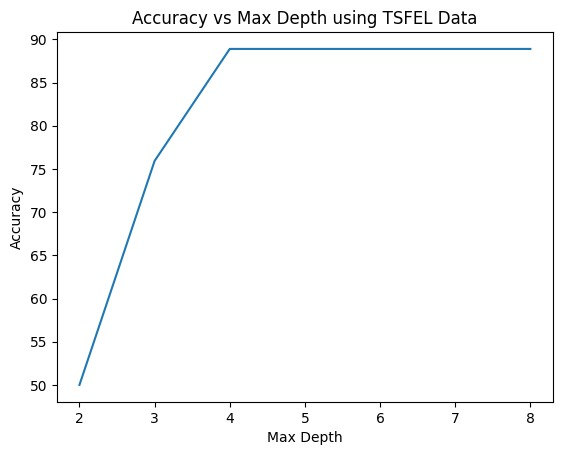

```` Which model performs better, Decision Tree Classifier or Few shot prompting on LLM? ````<br>
The decision tree has an accuracy of ~90% and the few shot learning gets an accuracy of ~50% <br> 
Therefore, the ```Decision tree``` classifier performs better than Few shot prompted LLMs<br>
<br>
```` Why? ````<br>
Some potential reasons that could explain this accuracy gap are:<br>
---> The Decision tree gets more training data to learn from, whereas the amount of training data that few shot learning can use is limited due to the Groq token limit<br>
---> In general, Decision tree performs better than LLMs when it comes to numerical data like the one that we are using<br>
---> The Decision tree is a more complex model and therefore it can better fit such large amounts of numerical data<br>

In [38]:
#TODO: Add results of decision trees predictions on the same test set

### Task 3.3
#### What are the limitations of Zero-Shot Learning and Few-Shot Learning in the context of classifying human activities based on featurized accelerometer data?

###### Common limitations
* Both these models lack domain specific knowledge of the task that they are trying to perform
* Upon initial exploration, I noticed that both these models often overfit to one of the activities, and ~95% of the times predicted that activity only
* The model does great segregation between static and dynamic activities but struggles to specify the kind of activity the human is performing

###### Zero shot limitations
* The model has very little context of the activities and what the features are

###### Few shot limitations
* Even though we do pass some training data, there is scope for only a limited number of training example for any activity(due to token limit), which limits the amount of usable training data

### Task 3.4
#### What does the model classify when given input from an entirely new activity that it hasn't seen before?

In [83]:
from sklearn.tree import DecisionTreeClassifier

In [91]:
random_index = np.random.choice(range(1, 7))
activity_not_passed = activity_dictionary[activity_not_passed]
print(f"Activity not passed to the model: {activity_not_passed}")

Activity not passed to the model: SITTING


In [93]:
new_feature_vector = {}
for activity in activities:
    if activity != activity_not_passed:
        new_feature_vector[activity] = activity_feature_vectors[activity]

In [99]:
model_predictions = []
i = 0

for test_data, test_label in zip(np.array(x_test_tsfel), np.array(y_test_tsfel, dtype = 'int32')):
    model_query = f"""

**Forget all previous instructions**

* You are a multiclass classifier model.
* You will be given TSFEL featurized readings of humans performing one of the following 6 physical activities: WALKING, WALKING UPSTAIRS, WALKING DOWNSTAIRS, SITTING,  STANDING, LAYING
* The 1152 dimensional vector

Here are a few examples to illustrate:

{new_feature_vector}

* Provide ONLY the activity name. NOTHING ELSE.
For the input data below, VERY CAREFULLY identify the activity being performed: Input --> {test_data}
    """ 
    model_answer = llm.invoke(model_query)
    model_predictions.append(model_answer.content)

    i += 1
    print("Test sample number:", i)
    print("Few shot:",model_answer.content)
    # print(quantitative_query_few_shot)
    
    print("Correct:", activity_dictionary[test_label[0]])
    # print(few_shot_predictions)    
    print("---------------------------------------------------------")
    time.sleep(1.5)

Test sample number: 1
Few shot: WALKING
Correct: WALKING DOWNSTAIRS
---------------------------------------------------------
Test sample number: 2
Few shot: WALKING DOWNSTAIRS
Correct: WALKING
---------------------------------------------------------
Test sample number: 3
Few shot: WALKING
Correct: WALKING UPSTAIRS
---------------------------------------------------------
Test sample number: 4
Few shot: STANDING
Correct: STANDING
---------------------------------------------------------
Test sample number: 5
Few shot: STANDING
Correct: STANDING
---------------------------------------------------------
Test sample number: 6
Few shot: WALKING
Correct: WALKING
---------------------------------------------------------
Test sample number: 7
Few shot: WALKING DOWNSTAIRS
Correct: WALKING
---------------------------------------------------------
Test sample number: 8
Few shot: STANDING
Correct: STANDING
---------------------------------------------------------
Test sample number: 9
Few shot: 

In [100]:
print(f"Model accuracy: {accuracy(y_test, model_predictions)}")

Model accuracy: 0.4444444444444444


In [101]:
print(f"Fraction of test set that was {activity_not_passed}: {y_test.count(activity_not_passed)/len(y_test)}")
print(f"Fraction of model predictions that were {activity_not_passed}: {model_predictions.count(activity_not_passed)/len(model_predictions)}")

Fraction of test set that was SITTING: 0.16666666666666666
Fraction of model predictions that were SITTING: 0.0


As we can see from the results above, if training example for one of the activities was not passed to the model (the training examples were not passed but the given activity label was passed), the model actually didn't predict that activity even a single time.<br>
<br>
The model accuracy didn't suffer much because instead of the previous 6 class multiclass classification problem, the few shot learning now has to deal with a 5 class multiclass classification problem. 
<br>
* One might think that doing this has made our model better, but we need to keep in mind that accuracy is not the only evaluation metric

### Task 3.5
#### Test the model with random data (ensuring the data has the same dimensions and range as the previous input) and report the results.

In [110]:
x_train_tsfel.describe()

,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Average power,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,...,2_Wavelet variance_0,2_Wavelet variance_1,2_Wavelet variance_2,2_Wavelet variance_3,2_Wavelet variance_4,2_Wavelet variance_5,2_Wavelet variance_6,2_Wavelet variance_7,2_Wavelet variance_8,2_Zero crossing rate
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.0,126.0,126.000000,126.000000,1.260000e+02,...,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,419.243157,4.164708,10.468254,84.016665,2.476737,100.0,400.0,0.707260,0.944713,2.000000e-03,...,0.003734,0.014887,0.023436,0.033494,0.046731,0.061655,0.074714,0.083567,0.088771,21.261905
std,192.764664,1.622156,19.790376,38.630193,0.167700,0.0,0.0,0.317133,0.422665,8.708243e-19,...,0.005406,0.021553,0.031593,0.044196,0.061365,0.080001,0.093557,0.099105,0.100124,29.418682
min,0.088936,0.053279,2.000000,0.017823,0.710366,100.0,400.0,-0.174422,-0.167212,2.000000e-03,...,0.000013,0.000042,0.000054,0.000066,0.000073,0.000076,0.000076,0.000076,0.000076,0.000000
25%,419.960756,4.507520,3.000000,84.160472,2.479599,100.0,400.0,0.696672,0.955334,2.000000e-03,...,0.000124,0.000488,0.000968,0.001485,0.002182,0.003049,0.004205,0.005618,0.007111,0.000000
50%,510.131220,4.933321,4.000000,102.230705,2.494691,100.0,400.0,0.781815,1.046177,2.000000e-03,...,0.001126,0.004342,0.009509,0.016239,0.023030,0.031781,0.044345,0.056916,0.067970,0.000000
75%,530.702356,5.049620,5.000000,106.353177,2.504231,100.0,400.0,0.909740,1.205886,2.000000e-03,...,0.005095,0.020815,0.032401,0.046965,0.063643,0.089760,0.108135,0.123692,0.119324,41.000000
max,605.643846,5.150520,110.000000,121.371512,2.744582,100.0,400.0,1.024051,1.460914,2.000000e-03,...,0.025911,0.118783,0.148987,0.226023,0.294239,0.389366,0.442293,0.430111,0.439137,98.000000


In [112]:
ranges_df = x_train_tsfel.describe().loc[["min", "max"], :]
ranges

,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Average power,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,...,2_Wavelet variance_0,2_Wavelet variance_1,2_Wavelet variance_2,2_Wavelet variance_3,2_Wavelet variance_4,2_Wavelet variance_5,2_Wavelet variance_6,2_Wavelet variance_7,2_Wavelet variance_8,2_Zero crossing rate
min,0.088936,0.053279,2.0,0.017823,0.710366,100.0,400.0,-0.174422,-0.167212,0.002,...,0.000013,0.000042,0.000054,0.000066,0.000073,0.000076,0.000076,0.000076,0.000076,0.0
max,605.643846,5.150520,110.0,121.371512,2.744582,100.0,400.0,1.024051,1.460914,0.002,...,0.025911,0.118783,0.148987,0.226023,0.294239,0.389366,0.442293,0.430111,0.439137,98.0


In [122]:
ranges = []

for feature_min, feature_max in zip(ranges_df.loc["min", :], ranges_df.loc["max", :]):
    feature_range = (feature_min, feature_max)
    ranges.append(feature_range)
ranges[:25]

[(0.0889355129901322, 605.6438464917953),
 (0.05327893483532, 5.1505201325),
 (2.0, 110.0),
 (0.0178227480942148, 121.37151232300508),
 (0.7103664147175276, 2.7445820513574186),
 (100.0, 100.0),
 (400.0, 400.0),
 (-0.1744216, 1.024051),
 (-0.1672121, 1.460914),
 (0.002, 0.002),
 (0.004, 0.004),
 (0.006, 0.006),
 (0.008, 0.008),
 (0.01, 0.01),
 (0.012, 0.012),
 (0.014, 0.014),
 (0.016, 0.016),
 (0.018, 0.018),
 (0.02, 0.02),
 (0.9880635595714996, 1.0),
 (2.5464260941607257e-13, 0.0004213772151133),
 (2.370965330354911e-08, 0.0461191097304486),
 (1.0037650719496328e-08, 0.0069549139071706),
 (1.9851381648156124e-10, 0.0017128182996847),
 (9.217909585787697e-09, 0.0036767756882256)]

In [130]:
# set this number to vary the number of iterations
num_iterations = 15

In [131]:
for i in range(num_iterations):
    # The below lines of code sample random values form a uniform distribution from the feature ranges
    arr = [np.random.uniform(low, high, size=(1, 1))[0][0] for low, high in ranges]
    test_df = pd.DataFrame(np.array(arr).reshape(1, -1), columns = x_train_tsfel.columns)
    
    model_query = f"""

**Forget all previous instructions**

* You are a multiclass classifier model.
* You will be given TSFEL featurized readings of humans performing one of the following 6 physical activities: WALKING, WALKING UPSTAIRS, WALKING DOWNSTAIRS, SITTING,  STANDING, LAYING
* The 1152 dimensional vector

Here are a few examples to illustrate:

{activity_feature_vectors}

* Provide ONLY the activity name. NOTHING ELSE.
For the input data below, VERY CAREFULLY identify the activity being performed: Input --> {np.array(test_df)}
    """ 
    model_answer = llm.invoke(model_query)
    print("Iteration:", i+1)
    print("Few shot prediction:",model_answer.content)
    print("---------------------------------------------------------")
    time.sleep(1.5)

Iteration: 1
Few shot prediction: WALKING
---------------------------------------------------------
Iteration: 2
Few shot prediction: WALKING
---------------------------------------------------------
Iteration: 3
Few shot prediction: WALKING
---------------------------------------------------------
Iteration: 4
Few shot prediction: WALKING
---------------------------------------------------------
Iteration: 5
Few shot prediction: WALKING
---------------------------------------------------------
Iteration: 6
Few shot prediction: WALKING
---------------------------------------------------------
Iteration: 7
Few shot prediction: WALKING
---------------------------------------------------------
Iteration: 8
Few shot prediction: WALKING
---------------------------------------------------------
Iteration: 9
Few shot prediction: WALKING
---------------------------------------------------------
Iteration: 10
Few shot prediction: WALKING
---------------------------------------------------------

Upon encountering random uniformly sampled from the feature ranges, the few shot learning model predicts the activity to be ````WALKING````.<br>